# Sentinel-3 Level 3 LST product generation

## using Jupyter Notebook, SNAP and snapista

In [10]:
#importing libraries

import os
import sys
import time
from subprocess import Popen, PIPE, STDOUT
import glob
import shutil
from datetime import datetime
import numpy, matplotlib
try: 
    import rasterio
except:
    !pip install rasterio
    import rasterio
    from rasterio.plot import show

# snapista imports
from snapista import Graph
from snapista import Operator, OperatorParams

import sys
import os

In [2]:
from snapista import Graph
from snapista import Operator
from snapista import TargetBand
from snapista import TargetBandDescriptors
from snapista.binning import aggregators
from snapista.binning import BinningVariable, BinningOutputBands, BinningBand, Aggregators, BinningVariables
import lxml.etree as etree
import os

# You can get a list of operators by uncommented the line below
#Graph.list_operators()

In [3]:
import zipfile
import glob
import os
datadir='/home/jovyan/data'
workdir='/home/jovyan/work'
files=glob.glob(os.path.join(datadir,'S3*zip'))


for myfile in files:
    with zipfile.ZipFile(myfile, 'r') as zip_ref:
        zip_ref.extractall(workdir)

In [4]:
k=0
for filename in glob.iglob(workdir+'/*.SEN3/xfdumanifest.xml',recursive=True):
    inputs=os.path.dirname(filename)
    if k==0:
        inputpaths=inputs
    else:
        inputpaths=inputpaths+','+inputs
    k=k+1
print(inputpaths)

/home/jovyan/work/S3B_SL_2_LST____20200415T091022_20200415T091322_20200415T110825_0180_037_378_2340_LN2_O_NR_004.SEN3,/home/jovyan/work/S3B_SL_2_LST____20200414T205328_20200414T205628_20200414T231241_0179_037_371_0540_LN2_O_NR_004.SEN3,/home/jovyan/work/S3A_SL_2_LST____20200414T213303_20200414T213603_20200414T235210_0180_057_129_0540_LN2_O_NR_004.SEN3,/home/jovyan/work/S3B_SL_2_LST____20200415T090722_20200415T091022_20200415T110829_0179_037_378_2160_LN2_O_NR_004.SEN3,/home/jovyan/work/S3B_SL_2_LST____20200414T205628_20200414T205928_20200414T231728_0180_037_371_0720_LN2_O_NR_004.SEN3,/home/jovyan/work/S3A_SL_2_LST____20200414T213603_20200414T213903_20200414T235657_0179_057_129_0720_LN2_O_NR_004.SEN3


In [5]:
k=0
timeslist=[]

for file in inputpaths.split(','):
    name=os.path.basename(file)
    timeslist.append(name[16:47])
    if k==0:
        fileList=file+'/xfdumanifest.xml'
        pathList=file
    else:
        fileList=fileList+','+file+'/xfdumanifest.xml'
        pathList=pathList+','+(file)
    k=k+1
    message='['+str(k)+']:'+file
    print(message)
total=k
message='Total input files found :'+str(total)
print(message)
sortedlist=sorted(timeslist)
timestart=sortedlist[0][0:15]
timestop=sortedlist[-1][16:31]


[1]:/home/jovyan/work/S3B_SL_2_LST____20200415T091022_20200415T091322_20200415T110825_0180_037_378_2340_LN2_O_NR_004.SEN3
[2]:/home/jovyan/work/S3B_SL_2_LST____20200414T205328_20200414T205628_20200414T231241_0179_037_371_0540_LN2_O_NR_004.SEN3
[3]:/home/jovyan/work/S3A_SL_2_LST____20200414T213303_20200414T213603_20200414T235210_0180_057_129_0540_LN2_O_NR_004.SEN3
[4]:/home/jovyan/work/S3B_SL_2_LST____20200415T090722_20200415T091022_20200415T110829_0179_037_378_2160_LN2_O_NR_004.SEN3
[5]:/home/jovyan/work/S3B_SL_2_LST____20200414T205628_20200414T205928_20200414T231728_0180_037_371_0720_LN2_O_NR_004.SEN3
[6]:/home/jovyan/work/S3A_SL_2_LST____20200414T213603_20200414T213903_20200414T235657_0179_057_129_0720_LN2_O_NR_004.SEN3
Total input files found :6


## Creating graph

In [6]:
def stacking(myfilelist,myinputpaths,timestart,timestop):
    outputfile=os.path.join(workdir,'S3_L3_LST_'+timestart+'_'+timestop+'.tif')

    g = Graph()
    #ProductSet-Reader
    g.add_node(
        operator=Operator(
            "ProductSet-Reader",
            fileList=myfilelist
        ),
        node_id="read",
    )
    # Binning
    ag_avg = aggregators.AggregatorAvg(varName='LST',targetName='avg', outputCounts='false', outputSums='false', weightCoeff=1.0)
    ag_minmax = aggregators.AggregatorMinMax(varName='LST',targetName='min_max')
    myvar1=BinningVariable(name='variable_0',expression='cloud_in==false?LST:NaN',valid_expression='cloud_in.visible==false')
    binning = Operator('Binning')
    binning.sourceProductFormat = 'Sen3'
    binning.aggregatorConfigs = Aggregators([ag_avg,ag_minmax])
    binning.variableConfigs  = BinningVariables([myvar1])
    binning.sourceProductPaths = myinputpaths
    binning.outputFile = outputfile[:-4]+'.dim'
    binning.outputFormat='BEAM-DIMAP'
    g.add_node(operator=binning,
        node_id="binning",
        source="read",
    )
    ## Write to GeoTIFF-BigTIFF
    g.add_node(
        operator=Operator("Write", file=outputfile, formatName="GeoTIFF-BigTIFF"),
        node_id="write",
        source='binning',
    )

    ##############################
    ## Executing graph
    ##############################
    print(g)
    #Uncomment the line below to save the graph to disc
    g.save_graph('mystack.xml')
    g.run()

# Calling /Running the graph with the data

In [7]:
stacking(fileList,inputpaths,timestart,timestop)

aggregatorConfigs <snapista.binning.aggregators.Aggregators object at 0x7fd330264ca0>
bandConfigurations None
postProcessorConfig None
productCustomizerConfig None
variableConfigs <snapista.binning.binning_variables.BinningVariables object at 0x7fd330264f10>
gpt binary: /opt/conda/snap/bin/gpt
working dir: .

<graph>
  <version>1.0</version>
  <node id="read">
    <operator>ProductSet-Reader</operator>
    <sources/>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <fileList>/home/jovyan/work/S3B_SL_2_LST____20200415T091022_20200415T091322_20200415T110825_0180_037_378_2340_LN2_O_NR_004.SEN3/xfdumanifest.xml,/home/jovyan/work/S3B_SL_2_LST____20200414T205328_20200414T205628_20200414T231241_0179_037_371_0540_LN2_O_NR_004.SEN3/xfdumanifest.xml,/home/jovyan/work/S3A_SL_2_LST____20200414T213303_20200414T213603_20200414T235210_0180_057_129_0540_LN2_O_NR_004.SEN3/xfdumanifest.xml,/home/jovyan/work/S3B_SL_2_LST____20200415T090722_20200415T091022_20200415T110829_0179_037_378

# Creating metadata of generated file

In [11]:
# Creating metadata output file
source=glob.glob('/home/jovyan/work/*tif')[0]
#source=outputname+'.tif'

print(source)
# Creating metadata output file
destination=source
properties=destination+'.properties'
src=rasterio.open(destination)
BBOX=src.bounds
print(BBOX)
print(src.transform)
xres=src.transform[0]
print(xres)
files=""
n=0


files=""
n=0
for name in inputpaths.split(','):
    if n==0:
        files=str(n+1)+' :'+os.path.basename(name)
    else:
        files=files+'\n'+str(n+1)+' :'+os.path.basename(name)
    n=n+1
print(files)


/home/jovyan/work/S3_L3_LST_20200414T205328_20200415T091322.tif
BoundingBox(left=-13.166666666666686, bottom=28.750000000000004, right=30.416666666666643, top=54.583333333333336)
| 0.08, 0.00,-13.17|
| 0.00,-0.08, 54.58|
| 0.00, 0.00, 1.00|
0.08333333333333333
1 :S3B_SL_2_LST____20200415T091022_20200415T091322_20200415T110825_0180_037_378_2340_LN2_O_NR_004.SEN3
2 :S3B_SL_2_LST____20200414T205328_20200414T205628_20200414T231241_0179_037_371_0540_LN2_O_NR_004.SEN3
3 :S3A_SL_2_LST____20200414T213303_20200414T213603_20200414T235210_0180_057_129_0540_LN2_O_NR_004.SEN3
4 :S3B_SL_2_LST____20200415T090722_20200415T091022_20200415T110829_0179_037_378_2160_LN2_O_NR_004.SEN3
5 :S3B_SL_2_LST____20200414T205628_20200414T205928_20200414T231728_0180_037_371_0720_LN2_O_NR_004.SEN3
6 :S3A_SL_2_LST____20200414T213603_20200414T213903_20200414T235657_0179_057_129_0720_LN2_O_NR_004.SEN3


# Creating quicklook of average LST

In [12]:
# Create visualisation of avg LST band
import subprocess
from subprocess import Popen, PIPE, STDOUT
s3_output=glob.glob(workdir+'/*tif')[0]
print(s3_output)

cmd=['/opt/conda/snap/bin/pconvert','-b','3','-c','/home/jovyan/resources/velocity.cpd',s3_output,'-f','png','-o',workdir]
print('Creating browse Level 3 average LST')
timeStarted = time.time()
process = Popen(cmd, stdout=PIPE, stderr=STDOUT)
r = b""
for line in process.stdout:
    r += line
    print(str(line))
process.wait()
timeDelta = time.time() - timeStarted                     # Get execution time.
print('Finished process in '+str(timeDelta)+' seconds.')
if process.returncode != 0 :
    message='Error creating L3 browse LST'
else:
    message='L3 browse LST average band successfully completed.'
    print( message)

/home/jovyan/work/S3_L3_LST_20200414T205328_20200415T091322.tif
Creating browse Level 3 average LST
b'INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters\n'
b'INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Incompatible GDAL 3.3.0 found on system. Internal GDAL 3.0.0 from distribution will be used.\n'
b'INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Internal GDAL 3.0.0 set to be used by SNAP.\n'
b'INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.\n'
b'reading file /home/jovyan/work/S3_L3_LST_20200414T205328_20200415T091322.tif\n'
b'INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Internal GDAL 3.0.0 set to be used by SNAP.\n'
b'INFO: org.hsqldb.persist.Logger: dataFileCache open start\n'
b'loading colour palette from: /home/jovyan/resources/velocity.cpd\n'
b"creating histogram for band 'avg_mean'...\n"
b'creating RGB image...\n'
b"writing RGB image to '/home/jovyan/work/

/home/jovyan/work/S3_L3_LST_20200414T205328_20200415T091322.png


/opt/conda/lib/python3.9/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


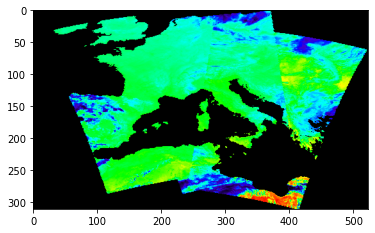

<AxesSubplot:>

In [13]:
# Reading output png
print(s3_output[:-3]+'png')
src = rasterio.open(s3_output[:-3]+'png')
show(src)

# Reprojecting into WebMercator for online map visualisation

In [14]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = 'EPSG:3857'

with rasterio.open(os.path.join(workdir,s3_output)) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(os.path.join(workdir,s3_output[:-4]+'_webmercator.tif'), 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)
            
## Creating the png in pseudomercator
# Create visualisation of avg LST band
s3_output=glob.glob(workdir+'/*webmercator.tif')[0]
print(s3_output)

cmd=['/opt/conda/snap/bin/pconvert','-b','3','-c','/home/jovyan/resources/velocity.cpd',s3_output,'-f','png','-o',workdir]
print('Creating browse Level 3 average LST')
timeStarted = time.time()
process = Popen(cmd, stdout=PIPE, stderr=STDOUT)
r = b""
for line in process.stdout:
    r += line
    print(str(line))
process.wait()
timeDelta = time.time() - timeStarted                     # Get execution time.
print('Finished process in '+str(timeDelta)+' seconds.')
if process.returncode != 0 :
    message='Error creating L3 browse LST'
else:
    message='L3 browse LST average band successfully completed.'
    print( message)

/home/jovyan/work/S3_L3_LST_20200414T205328_20200415T091322_webmercator.tif
Creating browse Level 3 average LST
b'INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters\n'
b'INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Incompatible GDAL 3.3.0 found on system. Internal GDAL 3.0.0 from distribution will be used.\n'
b'INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Internal GDAL 3.0.0 set to be used by SNAP.\n'
b'INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.\n'
b'reading file /home/jovyan/work/S3_L3_LST_20200414T205328_20200415T091322_webmercator.tif\n'
b'INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Internal GDAL 3.0.0 set to be used by SNAP.\n'
b'INFO: org.hsqldb.persist.Logger: dataFileCache open start\n'
b'loading colour palette from: /home/jovyan/resources/velocity.cpd\n'
b"creating histogram for band 'band_3'...\n"
b'creating RGB image...\n'
b"writing RGB image 

# Visualising output into interactive map

In [15]:
## Visualising output into an interactive map 
import folium
ymin=BBOX[1]
xmin=BBOX[0]
ymax=BBOX[3]
xmax=BBOX[2]
ymean=(ymax+ymin)/2
xmean=(xmax+xmin)/2

m = folium.Map([ymean, xmean], zoom_start=4, tiles='stamenterrain',crs='EPSG3857')

merc = os.path.join(workdir, s3_output[:-3]+'png')

if not os.path.isfile(os.path.join(workdir,s3_output)):
    print(f'Could not find {merc}')
else:
    img = folium.raster_layers.ImageOverlay(
        name='S3_LST_binned',
#        image=band,
        image=merc,
        bounds=[[ymin, xmin], [ymax, xmax]],
        opacity=0.6,
        interactive=True,
        cross_origin=False,
        zindex=1,
    )

    #folium.Popup('I am an image').add_to(img)

    img.add_to(m)
    folium.LayerControl().add_to(m)
    m.save(os.path.join('/home/jovyan', 'S3_L3_binning_map.html'))
m